# Requirement: Predict whether a household has an EV

## 1. Import libraries

In [ ]:
%pip install plotly
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install openpyxl

: 

In [1]:
# from helpers import *
from datetime import datetime, date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import seaborn as sns
sns.set()


pd.set_option('display.max_rows', 1000)

## 2. Import data
(note, loaded data from November 2021 as data is quite big and cannot be loaded at once)

In [18]:
def simple_col_name(x):
    x = x.lower().strip()
    return {'meter_id': 'meter',
            'start_timestamptz_ts': 'time',
            'interval_ts': 'time',
            'active_consumption_kwh': 'consumption',
            'active_generation_kwh': 'generation',
            'ev make': 'make',
            'ev model': 'model',
            'ev wall charger installed?': 'charger',
            'how many kms do you usually drive each year? \n(prior to the covid-19 pandemic)': 'drive_kms'
            }\
        .setdefault(x, x)


### EV training data

In [4]:
# Read excel file
df_ev_H = pd.read_excel('C:/Users/uft/Deakin University/Islam Khalil - EVChallenge/RawFiles/EV_training_meters_list.xlsx').rename(columns=simple_col_name)

# Create a variable equal to 1. All observations in this dataset have EV
df_ev_H['has_ev'] = 1

# Have a look at the first 5 observations of this dataset
df_ev_H.head()


,meter,make,model,charger,drive_kms,kms_group,has_ev
0,14702,Tesla,Model 3 and Model X,Yes,"Greater than 20,000",5,1
1,21463,Nissan,Leaf,No,"5,000 to 10,000",2,1
2,63317,Nissan,Leaf,No,"5,000 to 10,000",2,1
3,69825,Jaguar,ipace,Yes,"10,000 to 15,000",3,1
4,98536,Jaguar,ipace,No,"15,000 to 20,000",4,1


### Power consumption

In [22]:
# Read csv-formatter consumption data
df_consumeH = merge_csvs_into_df2(["C:/Users/uft/Deakin University/Islam Khalil - EVChallenge/RawFiles/consumption_training_data_oct21.csv", 
"C:/Users/uft/Deakin University/Islam Khalil - EVChallenge/RawFiles/consumption_training_data_nov21.csv"]).drop(['Unnamed: 0'], axis=1)

# Load dates as UTC (whatever timezone of raw data), then convert them to Melbourne's timezone
df_consumeH['start_timestamptz_ts'] = pd.to_datetime(df_consumeH['start_timestamptz_ts'],
                                                        infer_datetime_format=True, utc=True).dt.tz_convert(melb_tz)

# Rename variables
df_consumeH = df_consumeH.rename(columns=simple_col_name)

# Save data as a csv file
df_consumeH.to_csv('df_consumeH.csv')

df_consumeH.head()

loading: C:/Users/uft/Deakin University/Islam Khalil - EVChallenge/RawFiles/consumption_training_data_oct21.csv
loading: C:/Users/uft/Deakin University/Islam Khalil - EVChallenge/RawFiles/consumption_training_data_nov21.csv


,meter,element_uuid,time,consumption,generation
0,396,0a6acd53-80f8-4fef-91d0-63b56ff213c5,2021-10-01 10:00:00+10:00,0.1687,NaN
1,396,0a6acd53-80f8-4fef-91d0-63b56ff213c5,2021-10-01 10:30:00+10:00,0.0937,NaN
2,396,0a6acd53-80f8-4fef-91d0-63b56ff213c5,2021-10-01 11:00:00+10:00,0.0937,NaN
3,396,0a6acd53-80f8-4fef-91d0-63b56ff213c5,2021-10-01 11:30:00+10:00,0.0875,NaN
4,396,0a6acd53-80f8-4fef-91d0-63b56ff213c5,2021-10-01 12:00:00+10:00,0.1187,NaN


In [23]:
# Sum consumption by meter and time
df_consume_reduced = df_consumeH.groupby(['meter', 'time'])['consumption'].sum().reset_index()

# See head of that data
df_consume_reduced.head()

,meter,time,consumption
0,396,2021-10-01 10:00:00+10:00,0.1687
1,396,2021-10-01 10:30:00+10:00,0.0937
2,396,2021-10-01 11:00:00+10:00,0.0937
3,396,2021-10-01 11:30:00+10:00,0.0875
4,396,2021-10-01 12:00:00+10:00,0.1187


In [24]:
# Merge consumption with EV training data
ev_consume = pd.merge(left=df_consume_reduced, right=df_ev_reduced, on='meter', how='outer')
ev_consume.head()

# Replace missing value with 0
ev_consume['has_ev'] = np.where(ev_consume['has_ev'].isna(), 0, 1)
ev_consume['charger'] = np.where(ev_consume['charger'].isna(), 0, 1)

# Save dataframe to csv
ev_consume.to_csv('df_consume_reduced.csv')

In [25]:
# Resample data to create consumption of every 5 minutes
ev_consume_5 = ev_consume.set_index(['time']).groupby('meter').resample('5T', closed='right', label='right').ffill().drop('meter', axis=1).reset_index()

### Power quality

In [28]:
# Read csv-formatter power quality data
df_qualityH = merge_csvs_into_df2(["C:/Users/uft/Deakin University/Islam Khalil - EVChallenge/RawFiles/power_quality_training_data_oct21.csv", 
"C:/Users/uft/Deakin University/Islam Khalil - EVChallenge/RawFiles/power_quality_training_data_nov21.csv"]).drop(['Unnamed: 0'], axis=1)

# Load dates as UTC (whatever timezone of raw data), then convert them to Melbourne's timezone
df_qualityH['interval_ts'] = pd.to_datetime(df_qualityH['interval_ts'],
                                                 infer_datetime_format=True, utc=True)

# Rename variables
df_qualityH = df_qualityH.rename(columns=simple_col_name)

# Save data as a csv file
df_qualityH.to_csv('df_qualityH.csv')

df_qualityH.head()

loading: C:/Users/uft/Deakin University/Islam Khalil - EVChallenge/RawFiles/power_quality_training_data_oct21.csv
loading: C:/Users/uft/Deakin University/Islam Khalil - EVChallenge/RawFiles/power_quality_training_data_nov21.csv


,meter,channel_cd,time,voltage_lvt,amps_lct,power_factor_pf,number_of_phases,overground_or_underground
0,690991,a,2021-09-30 14:00:00+00:00,244.56,0.711253,-0.942,1,OH
1,690991,a,2021-09-30 14:05:00+00:00,244.35,0.701382,-0.941,1,OH
2,690991,a,2021-09-30 14:10:00+00:00,244.83,0.700637,-0.942,1,OH
3,690991,a,2021-09-30 14:15:00+00:00,245.20,0.710498,-0.943,1,OH
4,690991,a,2021-09-30 14:20:00+00:00,243.77,0.699575,-0.942,1,OH


In [29]:
# Drop unnecessary variables
quality_reduced = df_qualityH.drop( columns=['overground_or_underground'])

In [30]:
# Merge consumption quality data
ev_consume_quality = pd.merge(left=ev_consume_5, right=quality_reduced, on=['meter', 'time'], how='outer')
ev_consume_quality.head()

C:\Users\uft\AppData\Local\Temp\ipykernel_16304\4035094269.py:2: FutureWarning: Setitem-like behavior with mismatched timezones is deprecated and will change in a future version. Instead of raising (or for Index, Series, and DataFrame methods, coercing to object dtype), the value being set (or passed as a fill_value, or inserted) will be cast to the existing DatetimeArray/DatetimeIndex/Series/DataFrame column's timezone. To retain the old behavior, explicitly cast to object dtype before the operation.
  ev_consume_quality = pd.merge(left=ev_consume_5, right=quality_reduced, on=['meter', 'time'], how='outer')


,meter,time,consumption,charger,has_ev,channel_cd,voltage_lvt,amps_lct,power_factor_pf,number_of_phases
0,396,2021-10-01 10:00:00+10:00,0.1687,0.0,0.0,a,243.25,1.35372,-0.981,1.0
1,396,2021-10-01 10:05:00+10:00,0.1687,0.0,0.0,a,244.40,1.42857,-0.980,1.0
2,396,2021-10-01 10:10:00+10:00,0.1687,0.0,0.0,a,239.87,2.94574,0.903,1.0
3,396,2021-10-01 10:15:00+10:00,0.1687,0.0,0.0,a,240.46,1.48780,-0.984,1.0
4,396,2021-10-01 10:20:00+10:00,0.1687,0.0,0.0,a,243.59,1.50051,-0.983,1.0


In [65]:
ev_consume_quality.dtypes

meter                             int64
time                             object
consumption                     float64
charger                         float64
has_ev                            int32
channel_cd                       object
voltage_lvt                     float64
amps_lct                        float64
power_factor_pf                 float64
number_of_phases                float64
time2               datetime64[ns, UTC]
dtype: object

In [66]:
ev_consume_quality.head()

,meter,time,consumption,charger,has_ev,channel_cd,voltage_lvt,amps_lct,power_factor_pf,number_of_phases,time2
0,396,2021-10-01 10:00:00+10:00,0.1687,0.0,1,a,243.25,1.35372,-0.981,1.0,2021-10-01 00:00:00+00:00
1,396,2021-10-01 10:05:00+10:00,0.1687,0.0,1,a,244.40,1.42857,-0.980,1.0,2021-10-01 00:05:00+00:00
2,396,2021-10-01 10:10:00+10:00,0.1687,0.0,1,a,239.87,2.94574,0.903,1.0,2021-10-01 00:10:00+00:00
3,396,2021-10-01 10:15:00+10:00,0.1687,0.0,1,a,240.46,1.48780,-0.984,1.0,2021-10-01 00:15:00+00:00
4,396,2021-10-01 10:20:00+10:00,0.1687,0.0,1,a,243.59,1.50051,-0.983,1.0,2021-10-01 00:20:00+00:00


In [ ]:
ev_consume_quality.to_csv('ev_consume_quality.csv')

In [33]:
ev_consume_quality['time2'] = pd.to_datetime(ev_consume_quality['time'], utc=True)

## XGBoost

### Install package

In [ ]:
pip install xgboost
pip install --upgrade xgboost
pip install sklearn

In [1]:
import pandas as pd # load and manipulate data for One-Hot Coding
import numpy as np # calculate the mean and standard deviation
import xgboost as xgb #XGBoost stuff
from sklearn.model_selection import train_test_split # split data into training and testing sets
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer # for scoring during
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.metrics import confusion_matrix # creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draw a confution matrix

### Preliminary Xgboost model

In [3]:
import csv

In [17]:
# Import Data
ev_consume_quality=pd.read_csv(r'C:\Users\khalil\OneDrive - Deakin University\PhD Project\EVChallenge\python\Islam\df_analysis.csv')
ev_consume_quality.head()

,meter,raw_consumption_mean_2021-11-07,raw_consumption_mean_2021-11-14,raw_consumption_mean_2021-11-21,raw_consumption_mean_2021-11-28,raw_consumption_mean_2021-12-05,cons_above_80_sum_2021-11-07,cons_above_80_sum_2021-11-14,cons_above_80_sum_2021-11-21,cons_above_80_sum_2021-11-28,...,amps_above_80_sum_2021-11-21,amps_above_80_sum_2021-11-28,amps_above_80_sum_2021-12-05,amps_coeff_var_2021-11-07,amps_coeff_var_2021-11-14,amps_coeff_var_2021-11-21,amps_coeff_var_2021-11-28,amps_coeff_var_2021-12-05,phases_2021-11-07,has_ev_2021-11-07
0,396,0.084402,0.136256,0.093388,0.086013,NaN,6.0,30.0,2.0,4.0,...,53.0,21.0,NaN,0.820135,0.826640,0.924449,0.849198,NaN,1.0,0.0
1,428,0.082728,0.089256,0.108986,0.082701,0.097698,15.0,20.0,23.0,15.0,...,17.0,10.0,2.0,0.295562,0.292068,0.331285,0.302392,0.321687,1.0,0.0
2,829,0.254989,0.451691,0.391611,0.269229,0.421682,100.0,132.0,119.0,87.0,...,97.0,59.0,20.0,0.684145,0.710215,0.681733,0.674895,0.888724,1.0,0.0
3,4970,0.099732,0.092381,0.085597,0.087349,0.058526,22.0,27.0,18.0,14.0,...,106.0,113.0,37.0,0.997864,1.040740,1.288627,1.164944,25.667156,1.0,0.0
4,5228,0.174162,0.000000,0.040441,0.000000,0.050779,53.0,0.0,16.0,0.0,...,10.0,0.0,0.0,0.800832,0.682618,0.512009,0.617734,1.245383,1.0,0.0


In [36]:
# total consumption per week (coefficiet of variance)
X1 = [x for x in ev_consume_quality.columns.to_list() if 'total_consumption_coeff_var' in x or 'amps_coeff_var' in x or 'cons_above_80' in x or 'amps_above_80' in x] + ['phases_2021-11-07']
# total consumption per week (mean and standard deviation)
X2 = [x for x in ev_consume_quality.columns.to_list() if 'total_consumption_mean' in x or 'total_consumption_std' in x or 'amps_coeff_var' in x or 'cons_above_80' in x or 'amps_above_80' in x] + ['phases_2021-11-07']
# raw consumption per week (coefficiet of variance)
X3 = [x for x in ev_consume_quality.columns.to_list() if 'raw_consumption_coeff_var' in x or 'amps_coeff_var' in x or 'cons_above_80' in x or 'amps_above_80' in x] + ['phases_2021-11-07']
# raw consumption per week (mean and standard deviation)
X4 = [x for x in ev_consume_quality.columns.to_list() if 'raw_consumption_mean' in x or 'total_consumption_std' in x or 'amps_coeff_var' in x or 'cons_above_80' in x or 'amps_above_80' in x] + ['phases_2021-11-07']

In [43]:
Y = ev_consume_quality['has_ev']
X = ev_consume_quality[X1]

In [38]:
ev_consume_quality.dropna(inplace=True)
ev_consume_quality.shape

(1008, 24)

In [39]:
ev_consume_quality['has_ev'] = ev_consume_quality[['has_ev_2021-11-07']].astype('int').astype('category')

In [41]:
Y.shape

(1008,)

In [44]:
X.shape

(1008, 16)

In [26]:
# Number of meters having EV
sum(ev_consume_quality[Y])/len(ev_consume_quality[Y])

0.031746031746031744

In [34]:
len(ev_consume_quality['has_ev'].shape)

1

In [ ]:
ev_consume_quality.info()

In [51]:
# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, stratify=Y)

In [52]:
# Number of EV in train dataset
sum(Y_train)/len(Y_train)

0.031746031746031744

In [64]:
# Create a variable storing XGBClassifier
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=1, seed=42) 

# Create tree by running fit
clf_xgb.fit(X_train, 
            Y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, Y_test)])
''' early_stopping_rounds=10: stop if in the next 10 trees do not improve prediction
aucpr: a method to evaluate how well prediction made
eval_set: passing to test data, evaluating how many trees to be built
'''


[0]	validation_0-aucpr:0.02845
[1]	validation_0-aucpr:0.14882
[2]	validation_0-aucpr:0.12986
[3]	validation_0-aucpr:0.14184
[4]	validation_0-aucpr:0.13986
[5]	validation_0-aucpr:0.10116
[6]	validation_0-aucpr:0.08586
[7]	validation_0-aucpr:0.09771
[8]	validation_0-aucpr:0.09171
[9]	validation_0-aucpr:0.09533
[10]	validation_0-aucpr:0.09194
[11]	validation_0-aucpr:0.11592


C:\Users\khalil\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


' early_stopping_rounds=10: stop if in the next 10 trees do not improve prediction\naucpr: a method to evaluate how well prediction made\neval_set: passing to test data, evaluating how many trees to be built\n'

0

C:\Users\khalil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


'\nlast 2 rows is to mate confusion matrix pretty\n'

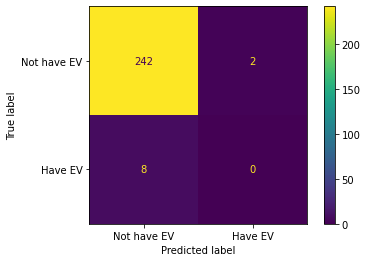

In [65]:
# Plot confusion matrix
plot_confusion_matrix(clf_xgb, 
                    X_test, 
                    Y_test, 
                    values_format='d', 
                    display_labels=["Not have EV", "Have EV"])
'''
last 2 rows is to mate confusion matrix pretty
'''

### Cross validation

In [68]:
'''GridSearchCV
Note: when data are imbalanced, the XGBoost manual says...
If you care only about the overall performance metric(AUD) o fyour prediction
      * Balance the positive and negative weights via scale_pos_weight
      * Use AUD for evaluation
Also not: I can GridSearchCV sequentially on subsets of parameter options, rather than all at in order to optimize parameters in a short period of time
'''

## Round 1:
param_grid = {
    'max_depth': [3, 4, 5], # test 3,4, 5 levels of tree
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1, 3, 5] # note: XGBoost recommends sum(negative instances)/sum(positive)=15.6 for EV data. For extremely unbalanced data, scale_pos_weight=sqrt(sum(negative examples)/sum(Positive examples))=4 
}
## Output: max_dept: a, learning_rate:b, gamma:c, reg_lambda:d, scale_pos_weight:e
## for those parameters at the ends of their range, we should continue explore in Round 2. Supopse that learning_rate and reg_lambda were at their range

In [74]:
## Round 2: remember to fill in outputs of previous round
param_grid = {
    'max_depth': [9, 10, 11],
    'learning_rate': [0.05],
    'gamma': [0],
    'reg_lambda': [1.0],
    'scale_pos_weight': [4]
}

## Optimal outputs are:

In [75]:
# Note: To speed up cross validation, and to further prevent overfitting.
# We are only using a random subset of the data (90%) and 
# are only using a random subset of the features (columns) {colsample_bytree=50%} per tree
optimal_params = GridSearchCV(
    estimator = xgb.XGBClassifier(objective='binary:logistic',
                                    seed=42,
                                    subsample = 0.9,
                                    colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=0, # Note: if you want to see what Grid Search is doing, set verbose=2
    n_jobs=10,
    cv=3
)

In [76]:
optimal_params.fit(X_train,
                    Y_train,
                    early_stopping_rounds=10,
                    eval_metric='auc',
                    eval_set=[(X_test, Y_test)],
                    verbose=False
)

print(optimal_params.best_params_)

{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 9, 'reg_lambda': 1.0, 'scale_pos_weight': 4}


C:\Users\khalil\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [ ]:
## Optimal parameters are: gamma= , learn_rate= , max_depth= , reg_lambda= .

### Final XGBoost Model

In [78]:
# Rember to fill above optimal parameters
clf_xgb = xgb.XGBClassifier(seed=42,
                            objective='binary:logistic',
                            gamma= 0,
                            learn_rate= 0.05,
                            max_depth= 9,
                            reg_lambda= 1,
                            scale_pos_weight= 4,
                            subsample=1,
                            colsample_bytree=1
                            )

clf_xgb.fit(X_train,
            Y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, Y_test)])


[02:21:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-aucpr:0.04472
[1]	validation_0-aucpr:0.08546
[2]	validation_0-aucpr:0.07660
[3]	validation_0-aucpr:0.07380
[4]	validation_0-aucpr:0.09511
[5]	validation_0-aucpr:0.09920
[6]	validation_0-aucpr:0.09849
[7]	validation_0-aucpr:0.10168
[8]	validation_0-aucpr:0.09374
[9]	validation_0-aucpr:0.10534
[10]	validation_0-aucpr:0.12289
[11]	validation_0-aucpr:0.12826
[12]	validation_0-aucpr:0.20712
[13]	validation_0-aucpr:0.21431
[14]	validation_0-aucpr:0.22433
[15]	validation_0-aucpr:0.13613
[16]	validation_0-aucpr:0.22275
[17]	validation_0-aucpr:0.22612
[18]	validation

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learn_rate=0.05,
              learning_rate=0.300000012, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=4,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

C:\Users\khalil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


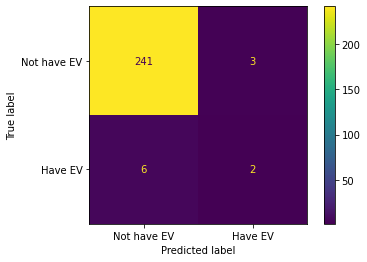

In [79]:
# Plot confusion matrix
plot_confusion_matrix(clf_xgb, 
                    X_test, 
                    Y_test, 
                    values_format='d', 
                    display_labels=["Not have EV", "Have EV"])

In [ ]:
# To save confusion matrix
confusion_matrix = plot_confusion_matrix(clf_xgb, 
                    X_test, 
                    Y_test, 
                    values_format='d', 
                    display_labels=["Not have EV", "Have EV"])
confusion_matrix.view(filename='confusion_matrix') ## save as pdf

### Draw tree

In [ ]:
# Rember to fill above optimal parameters
clf_xgb = xgb.XGBClassifier(seed=42,
                            objective='binary:logistic',
                            gamma= ,
                            learn_rate= ,
                            max_depth= ,
                            reg_lambda= ,
                            scale_pos_weight= ,
                            subsample=0.9,
                            colsample_bytree=0.5,
                            n_estimator=1) ## We set this to 1 to build the first tree
clf_xgb.fit(X_train, Y_train)  

# Now print out the wright, gain, cover etc. for the tree
# weight = number of times a feature is used in a branch or root accross all trees
# gain =  the average gain cross all splits that the feature is used in
# cover = the average coverage across all splits a feature is used in
# total_gain = the total gain across all splits the feature is used in
# total_cover = the total coverage across all splits the feature is used in
# Note: Since we only build one tree, gain = total_gain and cover=total_cover

bst = clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box',
                'style': 'rilled, rounded',
                'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
                'style': 'filled',
                'fillcolor': '#e48038'}

# Note: num_trees is not the number of trees to plot, but the specific tree you want to plot
# The default value is 0, but I'm setting it just to show it in action since it is counter-intuitive.
xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
                condition_node_params=node_params,
                leaf_node_params=leaf_params)

In [ ]:
# To save figure:
graph_data = xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
                condition_node_params=node_params,
                leaf_node_params=leaf_params)
graph_data.view(filename='xgboost_tree_customer_churn') ## save as pdf

# Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
## Preliminary random forest
rf = RandomForestClassifier(n_estimators=100, criterion='entropy') #criterion is either gini or entropy
rf.fit(X_train, Y_train)
prediction_test = rf.predict(X=X_test)

In [ ]:
# Accuracy on Test
print('Training accuracy is: ', rf.score(X_train, Y_train))

# Accuracy on train
print('Testing accuracy is:', rf.score(X_test, Y_test))

In [ ]:
# Confusion matrix
cm = confusion_matrix(Y_test, prediction_test)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=rf.classes_)

In [ ]:
# Tuning forest tree - find optimal parameters
from itertools import product


n_estimator=100
max_features = [1, 'sqrt', 'log2']
max_depths = ['None', 2, 3, 4, 5]
for f, d in product(max_features, max_depths):
    rf = RandomForestClassifier(n_estimators=n_estimator,
                                criterion='entropy',
                                max_features=f,
                                max_depth=d,
                                n_jobs=2,
                                random_state=42)
rf.fit(X_train, Y_train)
prediction_test = rf.predict(X=X_test)
print('Classification accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(Y_test, prediction_test)))


# Confusion matrix
cm2 = confusion_matrix(Y_test, prediction_test)
cm_norm2 = cm2/cm2.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm2, classes=rf.classes_)

# From these confusion matrix, identify the best parameters

# Decision tree